In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
from tqdm import tqdm

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

### 1. 요일,일자 변환

In [3]:
def transform_day_to_num(x) :
    if x == '월' :
        return 5
    elif x == '화' :
        return 4
    elif x == '수' :
        return 3
    elif x == '목' :
        return 2
    else :
        return 1        

In [4]:
train['요일'] = train['요일'].apply(transform_day_to_num)
test['요일'] = test['요일'].apply(transform_day_to_num)

***

In [5]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

In [6]:
train['년'] = train['일자'].dt.year
test['년'] = test['일자'].dt.year

In [7]:
train['월'] = train['일자'].dt.month
test['월'] = test['일자'].dt.month

In [8]:
train['일'] = train.일자.dt.day
test['일'] = test.일자.dt.day

In [9]:
train['주'] = train.일자.dt.week
test['주'] = test.일자.dt.week

In [10]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

In [11]:
train['회사출근_shift1'] = train['출근'].shift(1).fillna(train['출근'].mean())
test['회사출근_shift1'] = test['출근'].shift(1).fillna(test['출근'].mean())

train['회사출근_shift5'] = train['출근'].shift(5).fillna(train['출근'].mean())
test['회사출근_shift5'] = test['출근'].shift(5).fillna(test['출근'].mean())

In [12]:
train['야근_shift1'] = train['본사시간외근무명령서승인건수'].shift(1).fillna(train['본사시간외근무명령서승인건수'].mean())
test['야근_shift1'] = test['본사시간외근무명령서승인건수'].shift(1).fillna(test['본사시간외근무명령서승인건수'].mean())

train['야근_shift5'] = train['본사시간외근무명령서승인건수'].shift(5).fillna(train['본사시간외근무명령서승인건수'].mean())
test['야근_shift5'] = test['본사시간외근무명령서승인건수'].shift(5).fillna(test['본사시간외근무명령서승인건수'].mean())

### 2. 코로나 단계 별

In [13]:
def transform_corona(x) :
    if x <1 :
        return 3
    elif x < 134:
        return 2
    elif x < 221 :
        return 1
    else :
        return 0

In [14]:
train['코로나단계']=train['현본사소속재택근무자수'].apply(transform_corona)
test['코로나단계']=test['현본사소속재택근무자수'].apply(transform_corona)

In [15]:
ghkrwlswktn=train.groupby(['년','월'])['현본사소속재택근무자수'].sum().reset_index()
ghkrwlswktn['현본사소속재택근무자수_month']=ghkrwlswktn.현본사소속재택근무자수
ghkrwlswktn.drop('현본사소속재택근무자수',axis=1,inplace=True)
train=pd.merge(train,ghkrwlswktn,on=['년','월'],how='left')

In [16]:
ghkrwlswktn=test.groupby(['년','월'])['현본사소속재택근무자수'].sum().reset_index()
ghkrwlswktn['현본사소속재택근무자수_month']=ghkrwlswktn.현본사소속재택근무자수
ghkrwlswktn.drop('현본사소속재택근무자수',axis=1,inplace=True)
ghkrwlswktn['현본사소속재택근무자수_month'][0]=ghkrwlswktn['현본사소속재택근무자수_month'][0]+6295
test=pd.merge(test,ghkrwlswktn,on=['년','월'],how='left')

### 3. 신입사원 들어온 날(몇명이 들어왔나)

In [17]:
train['정원수증감']=train.본사정원수.diff(periods=1).fillna(0)
test['정원수증감']=test.본사정원수.diff(periods=1).fillna(0)

In [18]:
train['초기정원차분']=train.본사정원수-2601
test['초기정원차분']=test.본사정원수-2601

### 4. 요일 별로 밥먹는 인원 차이가 있을 꺼같은데 ...
- meanencoding 쓴다. 오버피팅의 위험이 있다.

In [19]:
train_1=train.copy()

In [20]:
mean=train_1['중식계'].mean()
agg=train_1.groupby('요일')['중식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_중식계']=train['요일'].map(smooth)
test['요일_중식계']=test['요일'].map(smooth)

In [21]:
mean=train_1['석식계'].mean()
agg=train_1.groupby('요일')['석식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_석식계']=train['요일'].map(smooth)
test['요일_석식계']=test['요일'].map(smooth)

### 5. 휴가 간 퍼센트를 수치로 하여 열 생성

In [22]:
train['휴가비율']=(train.본사휴가자수/train.본사정원수)*100
test['휴가비율']=(test.본사휴가자수/test.본사정원수)*100

In [23]:
def transform_rest(x) :
    if x <2.569236 :
        return 0
    elif x< 3.734756:
        return 1
    elif x< 6.562848:
        return 2
    else :
        return 3

In [24]:
train['휴가퍼센트']=train['휴가비율'].apply(transform_rest)
test['휴가퍼센트']=test['휴가비율'].apply(transform_rest)

### 6. 출장자 수가 어느정도인지 보는 것, 위의 방법으로 해도 된다.
- 문자형이기 때문에 따로 원핫이나 그런것을 해줘야함

In [25]:
train['출장비율']=(train.본사출장자수/train.본사정원수)*100
test['출장비율']=(test.본사출장자수/test.본사정원수)*100

In [26]:
for i in np.arange(0.25,1,0.25):
    print(int(i*100),'%: ',train.출장비율.quantile(q=i))

25 %:  7.685325264750379
50 %:  8.803353658536585
75 %:  9.844372059355774


In [27]:
def f1(x) :
    if x <7.685325264750379 :
        return 0
    elif x< 8.803353658536585:
        return 1
    elif x< 9.844372059355774:
        return 2
    else :
        return 3

In [28]:
train['출장퍼센트']=train['출장비율'].apply(f1)
test['출장퍼센트']=test['출장비율'].apply(f1)

In [29]:
#train = pd.concat([train, pd.get_dummies(train['출장퍼센트'])], axis=1)
#test = pd.concat([test, pd.get_dummies(test['출장퍼센트'])], axis=1)

### 7. 본사시간외근무명령서승인건수가 많았던 다음 날 식사 인원이 적을 것으로 판단.
- 본사시간외근무명령서승인건수의 값을 하루씩 미룬 값을 입력한다.

In [30]:
from datetime import datetime, timedelta

In [31]:
train1=train.copy()
train1['일자']=train1.일자+timedelta(days=1)
train1=train1[['일자','본사시간외근무명령서승인건수']]
train1.columns=['일자','전날야간근무']
train=pd.merge(train,train1,on='일자',how='left')

In [32]:
test1=test.copy()
test1['일자']=test1.일자+timedelta(days=1)
test1=test1[['일자','본사시간외근무명령서승인건수']]
test1.columns=['일자','전날야간근무']
test=pd.merge(test,test1,on='일자',how='left')

Null 값은 평균으로 넣어 준다.

In [33]:
test.전날야간근무.fillna(test.본사시간외근무명령서승인건수.mean(),inplace=True)
train.전날야간근무.fillna(train.본사시간외근무명령서승인건수.mean(),inplace=True)

### 8. 금요일 저녁에는 많이 안 먹지 않을까 하는 생각

In [34]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

공휴일 지정 노가다....

In [35]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] = 2
test['공휴일전후'][20] = 1

**원핫인코딩**

In [36]:
#train = pd.get_dummies(train, columns=['공휴일전후'])
#test = pd.get_dummies(test, columns=['공휴일전후'])

In [37]:
test['공휴일전후'][20] = 0

### 9. 메뉴 토큰화하여 일반적인 계산으로 해준 것

In [38]:
train['조식메뉴토큰'] = train['조식메뉴'].str.split(' ')
train['중식메뉴토큰'] = train['중식메뉴'].str.split(' ')
train['석식메뉴토큰'] = train['석식메뉴'].str.split(' ')

test['조식메뉴토큰'] = test['조식메뉴'].str.split(' ')
test['중식메뉴토큰'] = test['중식메뉴'].str.split(' ')
test['석식메뉴토큰'] = test['석식메뉴'].str.split(' ')

In [39]:
def get_menu_comp_cnt(data) :
    menu_cnt = []
    for token in data :
        comp_cnt = 0
        for text in token :
            if (len(text) > 1) & (text.startswith("(") != 1) :
                comp_cnt += 1
            else :
                pass
        menu_cnt.append(comp_cnt)
    return menu_cnt

In [40]:
train['중식메뉴수'] = get_menu_comp_cnt(train['중식메뉴토큰'])
train['석식메뉴수'] = get_menu_comp_cnt(train['석식메뉴토큰'])

test['중식메뉴수'] = get_menu_comp_cnt(test['중식메뉴토큰'])
test['석식메뉴수'] = get_menu_comp_cnt(test['석식메뉴토큰'])

In [41]:
def get_menu_nunique(data) :
    menu_n_list = []
    for token in data :
        menu_n = 0
        for text in token :
            if  '/' in text  :
                menu_nunique = text.count('/') + 1
                menu_n += menu_nunique
            else :
                pass
        menu_n_list.append(menu_n)
    return menu_n_list

In [42]:
train['석식선택메뉴'] = get_menu_nunique(train['석식메뉴토큰'])
train['중식선택메뉴'] = get_menu_nunique(train['중식메뉴토큰'])

In [43]:
test['석식선택메뉴'] = get_menu_nunique(test['석식메뉴토큰'])
test['중식선택메뉴'] = get_menu_nunique(test['중식메뉴토큰'])

***

In [44]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

In [45]:
for i in np.arange(0.25,1,0.25):
    print(int(i*100),'%: ',train.출근.quantile(q=i))

25 %:  2281.0
50 %:  2357.0
75 %:  2461.0


In [46]:
def f1(x) :
    if x <2281.0 :
        return 0
    elif x< 2357.0:
        return 1
    elif x< 2461.0:
        return 2
    else :
        return 3

In [47]:
train['출근퍼센트']=train['출근'].apply(f1)
test['출근퍼센트']=test['출근'].apply(f1)

In [48]:
def transform_season(x) :
    if 3<=x<=5 :
        return '봄'
    elif 6<=x<=8:
        return '여름'
    elif 9<=x<=11 :
        return '가을'
    else :
        return '겨울'

In [49]:
train['월_계절']=train['월'].apply(transform_season)
test['월_계절']=test['월'].apply(transform_season)

In [50]:
train = pd.concat([train, pd.get_dummies(train['월_계절'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['월_계절'])], axis=1)

In [51]:
def transform_week(x) :
    if 9<=x<=22 :
        return '주_봄'
    elif 23<=x<=35:
        return '주_여름'
    elif 36<=x<=48 :
        return '주_가을'
    else :
        return '주_겨울'

In [52]:
train['주_계절']=train['주'].apply(transform_week)
test['주_계절']=test['주'].apply(transform_week)

In [53]:
train = pd.concat([train, pd.get_dummies(train['주_계절'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['주_계절'])], axis=1)

In [54]:
test['주_가을']=0
test['주_여름']=0
test['가을']=0
test['여름']=0

In [55]:
def transform_day(x) :
    if 1<=x<=10 :
        return '초_일'
    elif 11<=x<=20:
        return '중_일'
    else :
        return '말_일'

In [56]:
train['초중말일자']=train['일'].apply(transform_day)
test['초중말일자']=test['일'].apply(transform_day)

In [57]:
train = pd.concat([train, pd.get_dummies(train['초중말일자'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['초중말일자'])], axis=1)

In [58]:
train['lunch_length'] = train['중식메뉴'].apply(lambda x : len(x))
train['dinner_length'] = train['석식메뉴'].apply(lambda x : len(x))

test['lunch_length'] = test['중식메뉴'].apply(lambda x : len(x))
test['dinner_length'] = test['석식메뉴'].apply(lambda x : len(x))

In [59]:
### 연말 연초
train['월일'] = train['일자'].astype(str)
test['월일'] = test['일자'].astype(str)
train['월일'] = train['월일'].apply(lambda x : x[5:10])
test['월일'] = test['월일'].apply(lambda x : x[5:10])

In [60]:
def malcho(x):
    if (x[0:2] == '12' and int(x[3:5]) >= 20) or (x[0:2] == '01' and int(x[3:5]) <= 10):
        return 1
    else:
        return 0

In [61]:
train['연말연초'] = train['월일'].apply(malcho)
test['연말연초'] = test['월일'].apply(malcho)

In [62]:
train['month'] = train['일자'].dt.month
test['month'] = test['일자'].dt.month

In [63]:
train['day'] = train['일자'].dt.day
test['day'] = test['일자'].dt.day

In [64]:
train['weekly_num'] = train['day'].apply(lambda x : 1 if (x>=1) and (x<=7)
                                                  else 2 if (x>7) and (x<=14)
                                                  else 3 if (x>14) and (x<=21)
                                                  else 4 if (x>21) and (x<=28) else 5)

test['weekly_num'] = test['day'].apply(lambda x : 1 if (x>=1) and (x<=7)
                                                  else 2 if (x>7) and (x<=14)
                                                  else 3 if (x>14) and (x<=21)
                                                  else 4 if (x>21) and (x<=28) else 5)    

### 메뉴 처리

In [65]:
category = pd.read_excel('../input/대분류중분류.xlsx')

In [66]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        elif '/' in i:
            x_.extend(i.split('/'))
        elif '*' in i:
            x_.extend(i.split('*'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [67]:
train['조식메뉴_split'] = train['조식메뉴'].apply(lambda x: get_food_embedding(x))
train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['조식메뉴_split'] = test['조식메뉴'].apply(lambda x: get_food_embedding(x))
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [68]:
import re
regex = "\(.*\)|\s-\s.*"
category['소분류'] = category['소분류'].apply(lambda x : re.sub(regex, '', x))

In [69]:
밥_list = list(category[category['대분류'] == '밥류']['소분류'])
과자빵_list = list(category[category['대분류'] == '과자 및 빵류']['소분류'])
면만두_list = list(category[category['대분류'] == '면 및 만두류']['소분류'])
죽_list = list(category[category['대분류'] == '죽류']['소분류'])
국_list = list(category[category['대분류'] == '국(탕)류']['소분류'])
찌개_list = list(category[category['대분류'] == '찌개류']['소분류'])
찜_list = list(category[category['대분류'] == '찜류']['소분류'])
구이_list = list(category[category['대분류'] == '구이류']['소분류'])
전_list = list(category[category['대분류'] == '전류']['소분류'])
볶음_list = list(category[category['대분류'] == '볶음류']['소분류'])
조림_list = list(category[category['대분류'] == '조림류']['소분류'])
튀김_list = list(category[category['대분류'] == '튀김류']['소분류'])
무침_list = list(category[category['대분류'] == '무침류']['소분류'])
김치_list = list(category[category['대분류'] == '김치류']['소분류'])
회_list = list(category[category['대분류'] == '회류']['소분류'])
젓갈_list = list(category[category['대분류'] == '젓갈류']['소분류'])
절임_list = list(category[category['대분류'] == '절임류']['소분류'])
장_list = list(category[category['대분류'] == '장류']['소분류'])
우유_list = list(category[category['대분류'] == '우유 및 유제품류']['소분류'])
음료_list = list(category[category['대분류'] == '음료류']['소분류'])
떡_list = list(category[category['대분류'] == '떡류']['소분류'])
원재료_list = list(category[category['대분류'] == '원재료']['소분류'])
주류_list = list(category[category['대분류'] == '주류']['소분류'])

In [70]:
num=[]
for t in range(train.shape[0]):
    for i in range(len(train['중식메뉴_split'][t])):
        token = train['중식메뉴_split'][t][i]
        if  token.endswith('주') or token in 주류_list:
            print(token)
            num.append(token)

In [71]:
num=pd.DataFrame(num)
num=pd.DataFrame(num.value_counts().index.values)
num=pd.DataFrame(num[0].apply(lambda x: x[0]))

In [72]:
num[0].values

array([], dtype=int64)

In [73]:
def get_Dae(data, col) :
    
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 25)), 
                          columns = ['밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류',
       '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류',
       '우유 및 유제품류', '음료류', '떡류', '원재료', '주류', '드레싱류', '조리_기타'])

    for t in range(data.shape[0]):
        for i in range(len(data[col][t])):
            token = data[col][t][i]
            if '덮밥' in token or '비빔밥' in token or '볶음밥' in token:
                recipe_df.at[t,'밥류'] += 3
            elif  token.endswith('밥') or '밥' in token or token in 밥_list:
                recipe_df.at[t, '밥류'] += 1 
                
            elif token.endswith('과자') or token in 과자빵_list:
                recipe_df.at[t, '과자 및 빵류'] += 3
                
            elif token.endswith('면') or token.endswith('만두') or '면' in token or '만두' in token or token in 면만두_list:
                recipe_df.at[t, '면 및 만두류'] += 4
                
            elif token.endswith('죽') or token in 죽_list or '죽' in token:
                recipe_df.at[t, '죽류'] += 2
                
            elif token.endswith('구이') or token in 구이_list or '구이' in token or token.endswith('데리야끼') or token.endswith('립') or\
                '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token:
                recipe_df.at[t, '구이류'] += 5
                
            elif token.endswith('국') or token.endswith('탕') or token in 국_list:
                if '만두' in token or '해물' in token or '도토리묵' in token or '냉국' in token or '사골' in token or '고기' in token or '해장' in token or token=='육개장'  or '수제비' in token or '옹심이' in token or '삼계탕' in token or '닭볶' in token or '전복' in token or '나주곰탕' in token or '감자탕' in token or '갈비' in token or '등뼈탕' in token or '들깨' in token or '홍합' in token or '새우' in token:
                    recipe_df.at[t, '국(탕)류'] += 4
                else:
                    recipe_df.at[t, '국(탕)류'] += 2
                    
            elif token.endswith('찌개') or token in 찌개_list:
                if '차돌' in token or '갈비' in token or '고기' in token or '돼지' in token: 
                    recipe_df.at[t, '찌개류'] += 4
                else:
                    recipe_df.at[t, '찌개류'] += 2
                
            elif token.endswith('찜') or token in 찜_list or '찜' in token or '보쌈' in token or '수육' in token or '김치말이' in token:
                if '브로컬리들깨찜' in token or  '꽈리고추찜' in token or  '깻잎찜' in token or  '가지찜' in token or  '청경채찜' in token or '호박잎쌈' in token:
                    recipe_df.at[t, '찜류'] += 2
                else:
                    recipe_df.at[t, '찜류'] += 4
                
            elif token.endswith('전') or token in 전_list or '전병' in token:
                recipe_df.at[t, '전류'] += 3
                
            elif token.endswith('볶음') or token in 볶음_list or '볶음' in token or token == '깐풍연근' or \
                '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token:
                if '미역줄기볶음' in token or '마늘쫑볶음' in token or '카레감자채볶음' in token or '모둠버섯볶음' in token or '고구마순볶음' in token or '콩나물볶음' in token or '버섯볶음' in token or '멸치' in token or '가지볶음' in token or '애기새송이버섯볶음' in token or '파프리카감자채볶음' in token or '호박새우젓볶음' in token or '청경채새송이볶음' in token or '오이볶음' in token or '호박채나물볶음' in token or '도라지볶음' in token or '도라지나물볶음' in token or '고춧잎볶음' in token or '고구마줄기볶음' in token or '감자볶음' in token or '새송이버섯볶음' in token or '가지볶음' in token or '브로콜리버섯볶음' in token or '명엽채볶음' in token or '매운호박볶음' in token or '머위대들깨볶음' in token or '멸치볶음' in token:
                    recipe_df.at[t, '볶음류'] += 1
                else:
                    recipe_df.at[t, '볶음류'] += 3
                
            elif token.endswith('조림') or token in 조림_list or '조림' in token or '오향장육' in token or '동파육' in token:
                if '땅콩조림' in token or '연근조림' in token or '견과류조림' in token or '연근땅콩조림' in token or '새송이버섯조림' in token or '우엉조림' in token or '시래기조림' in token or '검정콩조림' in token or '꽈리고추어묵조림' in token or '단호박장조림' in token or '감자조림' in token or '견과류연근조림' in token or '고추장감자조림' in token or '꽈리고추감자조림' in token or '콩조림' in token:
                    recipe_df.at[t, '조림류'] += 1
                else:
                    recipe_df.at[t, '조림류'] += 3
            elif token.endswith('튀김') or token.endswith('치킨') or token.endswith('탕수육') or '치킨' in token or '탕수' in token or token in 튀김_list or\
                '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or\
                token.endswith('고로케') or '유린기' in token or '탕수' in token or token.endswith('닭') or '너겟' in token or\
                token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token:
                recipe_df.at[t, '튀김류'] += 5
                
            elif token.endswith('무침') or token in 무침_list or '무침' in token or '파채' in token or token.endswith('샐러드') or '양장피' in token\
            or '범벅' in token or token.endswith('채'):
                recipe_df.at[t, '무침류'] += 1
                
            elif token.endswith('김치') or token in 김치_list or '겉절이' in token:
                recipe_df.at[t, '김치류'] += 1
                
            elif token.endswith('회') or token in 회_list:
                recipe_df.at[t, '회류'] += 1
                
            elif token.endswith('젓갈') or token in 젓갈_list or '젓갈' in token:
                recipe_df.at[t, '젓갈류'] += 1
                
            elif token.endswith('절임') or token in 절임_list or '절임' in token:
                recipe_df.at[t, '절임류'] += 1
                
            elif token.endswith('장') or token in 장_list:
                recipe_df.at[t, '장류'] += 1
                
            elif token.endswith('우유') or token in 우유_list:
                recipe_df.at[t, '우유 및 유제품류'] += 1
                
            elif token.endswith('음료') or token in 음료_list or '요구르트' in token:
                recipe_df.at[t, '음료류'] += 1
                
            elif token.endswith('떡') or token in 떡_list:
                recipe_df.at[t, '떡류'] += 2
                
            elif token in 원재료_list or token == '연두부' or token.endswith('김') or '생' in token or token.endswith('쌈'):
                recipe_df.at[t, '원재료'] += 1
                
            elif token.endswith('주') or token in 주류_list:
                recipe_df.at[t, '주류'] += 1
                
            elif token.endswith('드레싱') or 'D' in token or '소스' in token:
                recipe_df.at[t, '드레싱류'] += 1
                
            else :
                recipe_df.at[t, '조리_기타'] += 1
            
    return recipe_df

In [74]:
tr_lunch = get_Dae(train, '중식메뉴_split')
tr_dinner = get_Dae(train, '석식메뉴_split')
ts_lunch = get_Dae(test, '중식메뉴_split')
ts_dinner = get_Dae(test, '석식메뉴_split')

In [75]:
tr_lunch['중식점수'] = tr_lunch.sum(axis=1)
tr_dinner['석식점수'] = tr_dinner.sum(axis=1)
ts_lunch['중식점수'] = ts_lunch.sum(axis=1)
ts_dinner['석식점수'] = ts_dinner.sum(axis=1)

In [76]:
train_ln = train.copy()
train_ln['중식점수'] = tr_lunch['중식점수']
train_dn = train.copy()
train_dn['석식점수'] = tr_dinner['석식점수']

test_ln = test.copy()
test_ln['중식점수'] = ts_lunch['중식점수']
test_dn = test.copy()
test_dn['석식점수'] = ts_dinner['석식점수']

### 메뉴이름 BPE 후 fasttext

In [77]:
#!pip install tokenizers

In [78]:
train['조식메뉴_split'] = train['조식메뉴_split'].astype(str)
train['중식메뉴_split'] = train['중식메뉴_split'].astype(str)
train['석식메뉴_split'] = train['석식메뉴_split'].astype(str)

test['조식메뉴_split'] = train['조식메뉴_split'].astype(str)
test['중식메뉴_split'] = train['중식메뉴_split'].astype(str)
test['석식메뉴_split'] = train['석식메뉴_split'].astype(str)

In [79]:
total_menu = pd.concat([train['조식메뉴_split'], train['중식메뉴_split'], train['석식메뉴_split']], axis=0)
total_menu = total_menu.reset_index()
total_menu.drop('index', axis=1, inplace=True)
total_menu.columns = ['menu']
total_menu['menu'] = total_menu['menu'].astype(str)

In [80]:
import re
total_menu['menu'] = total_menu['menu'].apply(lambda x : re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`▁{|}~]', repl= '', string = x))
total_menu['menu'] = total_menu['menu'].apply(lambda x : re.sub('\s+', repl= ' ', string = x)) # 연속된 띄어쓰기 처리

In [81]:
with open('../input/train_menu.txt', 'w', encoding='utf-8') as f:
    for line in total_menu.menu.values:
        try:
            f.write(line+'\n')
        except TypeError as TE:
            print(line, TE)

In [82]:
from tokenizers import SentencePieceBPETokenizer

In [83]:
tokenizer = SentencePieceBPETokenizer()
tokenizer

Tokenizer(vocabulary_size=0, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [84]:
%%time
tokenizer.train(['../input/train_menu.txt'], vocab_size=5000)
tokenizer

Wall time: 168 ms


Tokenizer(vocabulary_size=4121, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [85]:
train['menu_sub_ln'] = np.nan
train['menu_sub_dn'] = np.nan
test['menu_sub_ln'] = np.nan
test['menu_sub_dn'] = np.nan

In [86]:
for i, t in enumerate(train['중식메뉴']):
    menu_sub = []
    output = tokenizer.encode(t)
    menu_sub += output.tokens
    train['menu_sub_ln'][i] = menu_sub

In [87]:
for i, t in enumerate(train['석식메뉴']):
    menu_sub = []
    output = tokenizer.encode(t)
    menu_sub += output.tokens
    train['menu_sub_dn'][i] = menu_sub

In [88]:
for i, t in enumerate(test['중식메뉴']):
    menu_sub = []
    output = tokenizer.encode(t)
    menu_sub += output.tokens
    test['menu_sub_ln'][i] = menu_sub

In [89]:
for i, t in enumerate(test['석식메뉴']):
    menu_sub = []
    output = tokenizer.encode(t)
    menu_sub += output.tokens
    test['menu_sub_dn'][i] = menu_sub

In [90]:
train['menu_sub_ln']

0       [▁, 쌀, 밥, 잡, 곡, 밥, ▁, 쌀, 현, 미, 흑, 미, 국내, 산, ▁,...
1       [▁, 쌀, 밥, 잡, 곡, 밥, ▁, 쌀, 현, 미, 흑, 미, 국내, 산, ▁,...
2       [▁, 카레, 덮, 밥, ▁, 쌀, 현, 미, 흑, 미, 국내, 산, ▁, 팽이, ...
3       [▁, 쌀, 밥, 잡, 곡, 밥, ▁, 쌀, 현, 미, 흑, 미, 국내, 산, ▁,...
4       [▁, 쌀, 밥, 잡, 곡, 밥, ▁, 쌀, 현, 미, 흑, 미, 국내, 산, ▁,...
                              ...                        
1200    [▁, 쌀, 밥, 흑, 미, 밥, 찰, 현, 미, 밥, ▁, 아욱, 국, ▁, 수제...
1201    [▁, 쌀, 밥, 수수, 밥, 찰, 현, 미, 밥, ▁, 냉, 이, 된장, 국, ▁...
1202    [▁, 전, 주, 비빔, 밥, 약, 고추장, ▁, 계란, 파, 국, ▁, 요거, 닭...
1203    [▁, 쌀, 밥, 흑, 미, 밥, 찰, 현, 미, 밥, ▁, 전, 주, 식, 콩나물...
1204    [▁, 쌀, 밥, 귀리, 밥, 찰, 현, 미, 밥, ▁, 들깨, 미역, 국, ▁, ...
Name: menu_sub_ln, Length: 1205, dtype: object

### 모델링

In [91]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor

In [92]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

In [93]:
select_column_ln = test_ln.columns[(test_ln.dtypes == 'int64') + (test_ln.dtypes == 'float64')+ (test_ln.dtypes == 'uint8')]
select_column_dn = test_dn.columns[(test_dn.dtypes == 'int64') + (test_dn.dtypes == 'float64')+ (test_dn.dtypes == 'uint8')]

In [94]:
select_columns_ln = select_column_ln.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '휴가비율', '출장비율'])
select_columns_dn = select_column_dn.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '휴가비율', '출장비율'])

In [95]:
select_columns_ln

Index(['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '회사출근_shift5',
       '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '정원수증감',
       '초기정원차분', '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후',
       '중식메뉴수', '석식메뉴수', '석식선택메뉴', '중식선택메뉴', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄',
       '주_가을', '주_여름', '가을', '여름', '말_일', '중_일', '초_일', 'lunch_length',
       'dinner_length', '연말연초', 'month', 'day', 'weekly_num', '중식점수'],
      dtype='object')

In [96]:
X1 = train_ln[select_columns_ln]
y1 = train.중식계
target1 = test_ln[X1.columns]

In [97]:
X2 = train_dn[select_columns_dn]
y2 = train.석식계
target2 = test_dn[X2.columns]

In [98]:
from lightgbm import LGBMRegressor
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:40<00:00,  2.35it/s]

(81, -84.02706047651627)


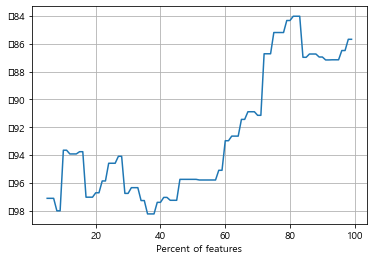

In [99]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X1, y1)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y1, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [100]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs1 = SelectPercentile(percentile=best_score[0]).fit(X1, y1)
X1_select = fs1.transform(X1)
target1_select = fs1.transform(target1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:42<00:00,  2.25it/s]

(93, -61.06522458218721)


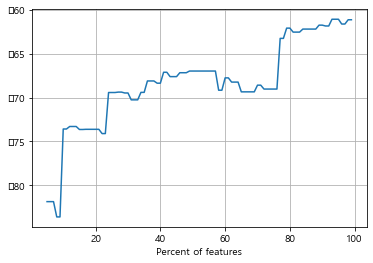

In [101]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X2, y2)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y2, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [102]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs2 = SelectPercentile(percentile=best_score[0]).fit(X2, y2)
X2_select = fs2.transform(X2)
target2_select = fs2.transform(target2)

In [103]:
print(X1_select.shape)
print(X1.columns[fs1.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 35)
['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '공휴일전후', '중식메뉴수', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄', '주_가을', '가을', '말_일', '중_일', '초_일', 'lunch_length', 'dinner_length', '연말연초', 'month', 'day', 'weekly_num', '중식점수']


In [104]:
print(X2_select.shape)
print(X2.columns[fs2.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 40)
['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후', '중식메뉴수', '석식메뉴수', '석식선택메뉴', '중식선택메뉴', '출근퍼센트', '겨울', '봄', '주_겨울', '주_가을', '주_여름', '가을', '여름', '말_일', '초_일', 'lunch_length', 'dinner_length', '연말연초', 'month', 'day', 'weekly_num', '석식점수']


In [105]:
X1 = train_ln[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', '요일_중식계', \
               '요일_석식계', '휴가퍼센트', '출장퍼센트', '공휴일전후', '중식메뉴수', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄', '주_가을', '가을', '말_일', '중_일', '초_일', 'lunch_length', \
               'dinner_length', '연말연초', 'weekly_num', '중식점수']]
target1 = test_ln[X1.columns]

In [106]:
X2 = train_dn[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', \
               '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후', '중식메뉴수', '석식메뉴수', '석식선택메뉴', '중식선택메뉴', '출근퍼센트', '겨울', '봄', '주_겨울', \
               '주_가을', '주_여름', '가을', '여름', '말_일', '초_일', 'lunch_length', 'dinner_length', '연말연초', 'weekly_num', '석식점수']]
y2 = train.석식계
target2 = test_dn[X2.columns]

In [126]:
X1.to_csv('../input/x1.csv')
X2.to_csv('../input/x2.csv')

In [127]:
target1.to_csv('../input/target1.csv')
target2.to_csv('../input/target2.csv')

In [128]:
X1 = X1.values
X2 = X2.values

In [129]:
lgbm = LGBMRegressor(random_state = 607, max_depth = 16, n_estimators = 20000, learning_rate = .01)

In [130]:
lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1[tr_idx], X1[val_idx]
    tr_y, val_y = y1[tr_idx], y1[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 13.7826	training's l2: 357.31	valid_1's l1: 65.5703	valid_1's l2: 7685.29
Early stopping, best iteration is:
[269]	training's l1: 55.6504	training's l2: 5626.09	valid_1's l1: 64.2173	valid_1's l2: 7497.12
FOLD MAE = 64.21726131084114
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 13.603	training's l2: 338.759	valid_1's l1: 63.9167	valid_1's l2: 6391.55
Early stopping, best iteration is:
[894]	training's l1: 28.5954	training's l2: 1520.02	valid_1's l1: 62.2709	valid_1's l2: 6037.99
FOLD MAE = 62.270913278976394
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 13.4893	training's l2: 354.051	valid_1's l1: 83.4797	valid_1's l2: 12399.2
Early stopping, best iteration is:
[1345]	training's l1: 20.6117	training's l2: 801.726	valid_1's l1: 82.545	valid_1's l2: 12325.6
FOLD MAE = 82.54496454496227
Training until validation scores don't im

In [131]:
lgbm_pred_1.sum()

48525.52036489487

In [132]:
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2[tr_idx], X2[val_idx]
    tr_y, val_y = y2[tr_idx], y2[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 8.18104	training's l2: 156.543	valid_1's l1: 52.4422	valid_1's l2: 5348.37
Early stopping, best iteration is:
[929]	training's l1: 17.5031	training's l2: 658.771	valid_1's l1: 51.9892	valid_1's l2: 5443.92
FOLD MAE = 51.98924662193306
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 8.16455	training's l2: 123.195	valid_1's l1: 53.373	valid_1's l2: 8139.24
Early stopping, best iteration is:
[547]	training's l1: 24.9238	training's l2: 1191.43	valid_1's l1: 52.387	valid_1's l2: 8187.28
FOLD MAE = 52.386961858153825
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 8.34605	training's l2: 162.94	valid_1's l1: 54.6952	valid_1's l2: 5557.9
Early stopping, best iteration is:
[504]	training's l1: 26.9745	training's l2: 1466.84	valid_1's l1: 53.1265	valid_1's l2: 5504.41
FOLD MAE = 53.12647539056981
Training until validation scores don't impr

In [133]:
lgbm_pred_2.sum()

22866.61988756614

In [134]:
X1 = train_ln[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', '요일_중식계', \
               '요일_석식계', '휴가퍼센트', '출장퍼센트', '공휴일전후', '중식메뉴수', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄', '주_가을', '가을', '말_일', '중_일', '초_일', 'lunch_length', \
               'dinner_length', '연말연초', 'weekly_num', '중식점수']]
target1 = test_ln[X1.columns]

In [135]:
X2 = train_dn[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', \
               '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후', '중식메뉴수', '석식메뉴수', '석식선택메뉴', '중식선택메뉴', '출근퍼센트', '겨울', '봄', '주_겨울', \
               '주_가을', '주_여름', '가을', '여름', '말_일', '초_일', 'lunch_length', 'dinner_length', '연말연초', 'weekly_num', '석식점수']]
y2 = train.석식계
target2 = test_dn[X2.columns]

In [136]:
ngb = NGBRegressor(n_estimators = 20000, verbose = 0, random_state = 607)

In [137]:
ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 67.46036020010908
FOLD MAE = 41.48245220572523
FOLD MAE = 44.341378149394544
FOLD MAE = 29.78346364517357
FOLD MAE = 27.535351496887465
FOLD MAE = 28.75441389715931
FOLD MAE = 24.053256973976296
FOLD MAE = 28.144610417042315
FOLD MAE = 23.216161264667683
FOLD MAE = 29.20267661790202
FOLD MAE = 24.881621590073518
FOLD MAE = 20.13003005662672
FOLD MAE = 22.04457681794623
FOLD MAE = 24.78081919149642
FOLD MAE = 21.369338507503095

NGBRegressor MAE = 30.478700735445557


In [138]:
ngb_pred_1.sum()

49433.79597032664

In [139]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [140]:
ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 54.71480487456918
FOLD MAE = 31.303761188413542
FOLD MAE = 25.175951398333247
FOLD MAE = 25.498015968768946
FOLD MAE = 26.512509099948765
FOLD MAE = 24.2583440203346
FOLD MAE = 25.02066456946373
FOLD MAE = 24.895268043441312
FOLD MAE = 22.869791638802297
FOLD MAE = 19.287223973897788
FOLD MAE = 18.275370110803117
FOLD MAE = 19.81462805086152
FOLD MAE = 17.852310891744725
FOLD MAE = 17.91172698901614
FOLD MAE = 17.00061647203618

NGBRegressor MAE = 24.692732486029005


In [141]:
ngb_pred_2.sum()

23042.524971991275

In [107]:
X1 = train_ln[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', '요일_중식계', \
               '요일_석식계', '휴가퍼센트', '출장퍼센트', '공휴일전후', '중식메뉴수', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄', '주_가을', '가을', '말_일', '중_일', '초_일', 'lunch_length', \
               'dinner_length', '연말연초', 'weekly_num', '중식점수']]
target1 = test_ln[X1.columns]

In [108]:
X2 = train_dn[['요일', '년', '월', '일', '주', '출근', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', '코로나단계', '현본사소속재택근무자수_month', '초기정원차분', \
               '요일_중식계', '요일_석식계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후', '중식메뉴수', '석식메뉴수', '석식선택메뉴', '중식선택메뉴', '출근퍼센트', '겨울', '봄', '주_겨울', \
               '주_가을', '주_여름', '가을', '여름', '말_일', '초_일', 'lunch_length', 'dinner_length', '연말연초', 'weekly_num', '석식점수']]
y2 = train.석식계
target2 = test_dn[X2.columns]

In [109]:
X1 = X1.astype(int)
X2 = X2.astype(int)
target1 = target1.astype(int)
target2 = target2.astype(int)

In [110]:
cat_features_ln = ['요일', '년', '월', '일', '주', '코로나단계', '휴가퍼센트', '출장퍼센트', '공휴일전후', '출근퍼센트', '겨울', '봄', '주_겨울', '주_봄', '주_가을', '가을', '말_일', '중_일', \
                   '초_일', '연말연초', 'weekly_num']
                  
cat_features_dn = ['요일', '년', '월', '일', '주', '코로나단계', '휴가퍼센트', '출장퍼센트', '전날야간근무', '공휴일전후', '출근퍼센트',  '겨울', '봄', '주_겨울', '주_가을', '주_여름', '가을', \
                   '여름', '말_일', '초_일', '연말연초', 'weekly_num']

In [111]:
from catboost import CatBoostRegressor, Pool
cb = CatBoostRegressor(iterations = 20000, learning_rate = 0.01, eval_metric = 'MAE', silent = True, 
                       loss_function = 'MAE')

In [112]:
cb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y, cat_features = cat_features_ln)
    val_data = Pool(data = val_x, label = val_y, cat_features = cat_features_ln)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target1, ntree_end = best) / 15
    cb_pred_1 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 166.6362090	test: 162.9091348	best: 162.9091348 (0)	total: 150ms	remaining: 49m 55s


KeyboardInterrupt: 

In [148]:
cb_pred_1

array([ 976.07609276,  932.16534714,  619.016611  , 1249.03549561,
       1025.96900118, 1005.57470042,  986.62320592,  718.71884124,
       1239.24208606, 1029.28112518,  814.89268428, 1197.59491078,
       1028.24866939, 1043.15050106,  872.25827733,  719.2193297 ,
       1242.18091545, 1017.43352615,  948.72296125,  871.52699024,
        644.46577114, 1083.97222322, 1026.12628804,  891.29730076,
        737.7341164 , 1245.4365468 , 1062.14190778, 1064.66550385,
        941.92621717,  694.97046535, 1252.35931379, 1048.49998453,
       1014.61581233,  871.29617502,  669.73575358, 1262.82876236,
       1014.39724802,  945.17674863,  863.79433876,  637.35128043,
       1234.63215334, 1000.08104412, 1005.73267745,  875.2803762 ,
        651.7843725 , 1232.00451707,  985.63450656,  988.42163217,
        860.54028658,  636.79984342])

In [149]:
cb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y, cat_features = cat_features_dn)
    val_data = Pool(data = val_x, label = val_y, cat_features = cat_features_dn)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target2, ntree_end = best) / 15
    cb_pred_2 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 97.6151769	test: 100.8308632	best: 100.8308632 (0)	total: 25.1ms	remaining: 8m 21s
5000:	learn: 17.9497627	test: 53.3111810	best: 53.1287145 (3573)	total: 2m 35s	remaining: 7m 45s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 53.12871453
bestIteration = 3573

Shrink model to first 3574 iterations.
FOLD MAE = 53.143539769381434
0:	learn: 97.7505684	test: 98.8698755	best: 98.8698755 (0)	total: 41.1ms	remaining: 13m 42s
5000:	learn: 18.6183032	test: 55.8433725	best: 55.8226674 (4914)	total: 2m 21s	remaining: 7m 3s
10000:	learn: 12.2340021	test: 55.5213862	best: 55.4128085 (9648)	total: 4m 33s	remaining: 4m 33s
15000:	learn: 8.8098631	test: 55.2491295	best: 55.2239853 (14304)	total: 6m 53s	remaining: 2m 17s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 55.115723
bestIteration = 15936

Shrink model to first 15937 iterations.
FOLD MAE = 55.115773740287395
0:	learn: 97.4239937	test: 104.1260484	best: 104.1260484 (0)	total: 21.1ms	remaining

In [150]:
cb_pred_1.sum()

47980.63443952518

In [151]:
cb_pred_2.sum()

22289.511249726515

In [152]:
sub_60 = pd.read_csv('../input/ensemble_all_2.csv')

In [153]:
submission['중식계'] = (lgbm_pred_1 + ngb_pred_1 + cb_pred_1) / 3

In [154]:
submission['석식계'] = (lgbm_pred_2 + ngb_pred_2 + cb_pred_2) / 3

### 49482.43247838575, 24917.37723101190

In [155]:
submission.중식계.sum()

48646.6502582489

In [156]:
submission.석식계.sum()

22732.88536976131

In [159]:
sub_60['중식계'].sum(), sub_60['석식계'].sum()

(50610.561968659684, 24069.984766997215)

In [547]:
submission.to_csv('0719날씨추가.csv', index = False)